# DSCI 235 Final Report


For my final report I chose to analyze some data related to home values in the Fort Collins, Colorado area. I pulled data from https://www.zillow.com/research/data/, specifically their Zillow Home Value Index (ZHVI). They have ZHVI data for single family homes, condos, homes with 1,2,3,4, or 5+ bedrooms, and top/bottom tier homes. We will be looking at all of these. The dataset we are working with is titled, ZHVI All Homes (SFR, Condo/Co-op) Time Series, Smoothed, Seasonally Adjusted($). Sorting through it, we will be looking at Zillows dataset that splits Fort Collins into zip-codes. Below I have inserted a screenshot of Zillow's explanantion of the data we will be looking at. 
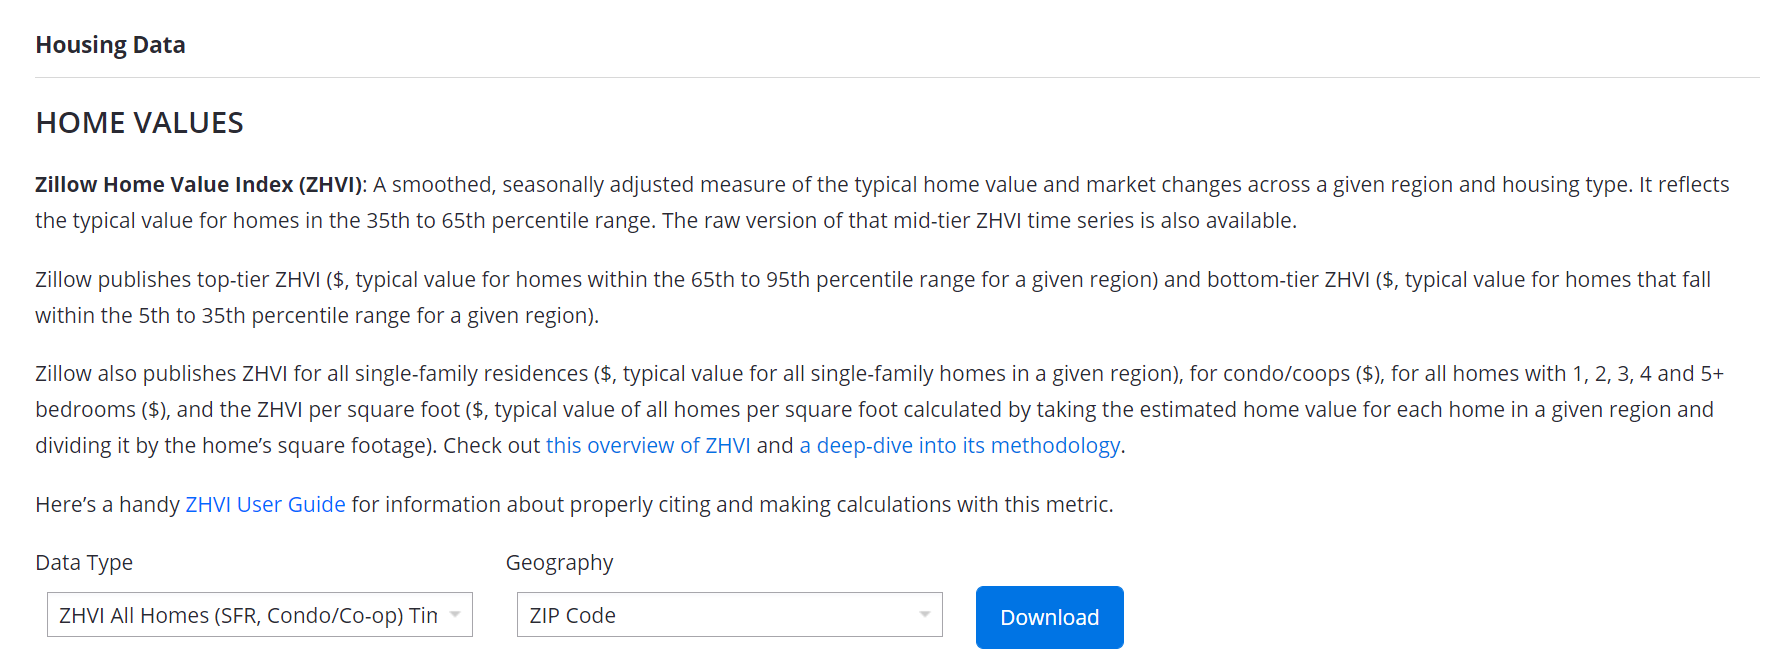
The data will include the columns; regionID, SizeRank, RegionName, RegionType, StateName, State, City, Metro, CountyName, and their average home value from 1996-present.  

In [382]:
# import our data and call it 
import numpy as np
import pandas as pd
ZipCodes = pd.read_csv("https://raw.githubusercontent.com/EvanJosef/DSCI235-FinalProject/main/ZipCodesGitHub.csv")
ZipCodes.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,...,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021
0,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,212230.0,212073.0,211661.0,211524.0,210956.0,211141.0,210927.0,211539.0,212435.0,213959.0,215637.0,216901.0,218379.0,219794.0,221644.0,222408.0,224141.0,224745.0,226041.0,225584.0,224463.0,222439.0,220700.0,220413.0,220434.0,220795.0,221290.0,222747.0,224112.0,225705.0,227435.0,...,496357.0,500405.0,503526.0,503225.0,501938.0,501843.0,502795.0,502064.0,501521.0,501274.0,502153.0,503444.0,503865.0,501585.0,498579,496921,497102,497935,498101,498432,497601,495769,493889,492312,491195,491444,492512,494846,496392,497102,497724,499152,501262,504040,506695,509141,511452,513457,515542,516747
1,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,283626.0,283367.0,282845.0,282702.0,282021.0,282109.0,281613.0,282177.0,283263.0,285213.0,287502.0,289462.0,292122.0,294249.0,296498.0,297115.0,298953.0,299676.0,300809.0,299983.0,298078.0,295135.0,292446.0,291350.0,289946.0,289597.0,290019.0,291823.0,293607.0,295572.0,298657.0,...,641008.0,646052.0,650275.0,650025.0,648263.0,647719.0,648810.0,648255.0,647878.0,647639.0,648481.0,649897.0,650355.0,646893.0,643472,641925,643124,643915,643760,643486,642773,640320,638242,635947,634193,634507,634554,635835,635617,635861,635967,637199,638751,641622,644350,647291,650118,652578,655761,658233
2,84640,9,60640,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,121416.0,121068.0,120713.0,120598.0,120344.0,120466.0,120472.0,121145.0,121983.0,122909.0,123830.0,124678.0,125602.0,126619.0,127881.0,128427.0,129480.0,129788.0,130231.0,129373.0,128502.0,127520.0,127044.0,127013.0,127430.0,128064.0,129006.0,130126.0,131083.0,132425.0,134039.0,...,300639.0,303679.0,306200.0,306681.0,305694.0,305613.0,306453.0,306766.0,306653.0,306692.0,307201.0,308643.0,309322.0,307475.0,305261,304175,305621,307126,308055,308405,308438,307360,306441,305498,305397,306212,307667,309720,310930,311505,312122,313557,315436,318103,320656,322886,324798,326776,328687,330093
3,84646,18,60647,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,168978.0,169125.0,169437.0,170030.0,170226.0,170646.0,171247.0,172452.0,173462.0,174072.0,174626.0,175235.0,177052.0,178921.0,180206.0,180128.0,180913.0,181734.0,182787.0,182139.0,181436.0,180370.0,179916.0,179712.0,178646.0,177670.0,177744.0,179718.0,181539.0,182518.0,182734.0,...,462740.0,466738.0,470263.0,470282.0,469178.0,469401.0,470120.0,469550.0,469273.0,469476.0,470723.0,472257.0,473550.0,472595.0,470004,468310,468188,468966,469318,469675,469556,468423,467508,467593,467510,468994,471432,475385,478682,480677,483012,486109,489621,493729,497579,500722,503938,506580,509584,511722
4,84620,28,60618,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,206297.0,206129.0,206073.0,206622.0,206676.0,206608.0,205941.0,206094.0,207020.0,208513.0,210130.0,211626.0,213102.0,214391.0,215370.0,214974.0,215466.0,216159.0,217469.0,217063.0,214727.0,211395.0,208272.0,206368.0,205280.0,205027.0,205422.0,206400.0,207567.0,208586.0,210320.0,...,489631.0,493484.0,496180.0,495553.0,494344.0,493962.0,494544.0,493540.0,492779.0,492004.0,492011.0,492646.0,493252.0,491266.0,488222,486028,485885,486532,487104,487285,486173,483324,48096

# Clean Up the Data


This data contains some unneccesary information, so let's clean it up. We are going to remove one of StateName (as StateName and State both contain State abbreviations), RegionID, SizeRank, Metro, and RegionType. At a bit of a further level, we need to remove every row that contains data for cities other than Fort Collins.   




In [383]:
ZipCodes = ZipCodes.drop(columns = ['RegionID', 'SizeRank', 'Metro', 'RegionType', 'StateName'])

In [384]:
ZipCodes = ZipCodes[ZipCodes['City'] == 'Fort Collins']
ZipCodes.set_index('RegionName')

,State,City,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,...,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021
RegionName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
80525,CO,Fort Collins,Larimer County,170051.0,169950.0,170124.0,170353.0,170659.0,170808.0,170901.0,170928.0,171009.0,171087.0,171162.0,171221.0,171280.0,171565.0,171690.0,171804.0,171852.0,172008.0,172317.0,172774.0,173315.0,173919.0,174493.0,175105.0,175599.0,175993.0,176313.0,176661.0,177171.0,177861.0,178514.0,179496.0,180327.0,181332.0,182098.0,182948.0,184009.0,...,407243.0,408840.0,410723.0,411687.0,412883.0,414033.0,416237.0,418209.0,420051.0,421388.0,423685.0,425407.0,427098.0,427206.0,428989,430456,430755,430525,430148,431674,432800,434449,434421,435618,436787,438760,438580,439022,441330,443985,446423,447876,449833,451910,454987,457722,460634,463979,468458,473077
80526,CO,Fort Collins,Larimer County,155075.0,155117.0,155246.0,155495.0,155690.0,155762.0,155674.0,155572.0,155508.0,155454.0,155397.0,155410.0,155456.0,155581.0,155684.0,155795.0,155963.0,156186.0,156635.0,157244.0,157845.0,158518.0,159054.0,159592.0,159944.0,160256.0,160363.0,160450.0,160713.0,161205.0,161758.0,162462.0,163233.0,164086.0,164920.0,165663.0,166713.0,...,373592.0,375468.0,377333.0,378694.0,380286.0,381787.0,383636.0,384832.0,386096.0,387268.0,389683.0,391763.0,393655.0,394206.0,395801,396932,396994,396804,396427,398042,399151,401237,401391,401875,402268,403151,403151,403723,406106,408585,411030,412599,414704,416480,419323,422318,425614,429436,433764,438269
80524,CO,Fort Collins,Larimer County,155979.0,156380.0,156913.0,157886.0,158853.0,159643.0,160458.0,161056.0,161639.0,161960.0,162383.0,162719.0,163212.0,163852.0,164392.0,164839.0,165082.0,165528.0,165944.0,166618.0,167299.0,168310.0,169180.0,170219.0,170886.0,171211.0,171364.0,171622.0,172404.0,173100.0,173692.0,174664.0,175674.0,177004.0,177834.0,178550.0,179306.0,...,420513.0,422462.0,424419.0,425290.0,426520.0,427824.0,430825.0,433479.0,435823.0,437015.0,439690.0,441662.0,443652.0,443724.0,445402,446096,445908,445064,444446,445606,446735,448463,448070,449016,450245,452800,453288,454372,457001,460057,462682,464486,466642,469138,472809,476106,479317,482787,487453,492674
80521,CO,Fort Collins,Larimer County,131319.0,131377.0,131695.0,132257.0,133026.0,133415.0,133640.0,133905.0,134343.0,134810.0,135034.0,135304.0,135555.0,136004.0,136327.0,136564.0,136477.0,136823.0,137418.0,138034.0,138370.0,138742.0,139316.0,139889.0,140301.0,140732.0,140970.0,141271.0,141688.0,142198.0,142731.0,143427.0,144271.0,145132.0,145945.0,146699.0,147790.0,...,369537.0,371900.0,374037.0,374224.0,374692.0,375677.0,378364.0,380506.0,382594.0,384235.0,387330.0,389434.0,390769.0,390825.0,392350,393954,394595,394790,394448,395993,397161,399467,399341,400497,401322,403259,403289,404011,406310,408715,411092,412579,414596,416388,419510,422316,425739,429340,434106,439009
80528,CO,Fort Collins,Larimer County,216415.0,216174.0,216271.0,216575.0,216989.0,217158.0,217116.0,217138.0,217350.0,217508.0,217936.0,218522.0,219499.0,220567.0,221574.0,222119.0,222685.0,223522.0,224716.0,226126.0,227331.0,228823.0,229747.0,230556.0,230689.0,231138.0,231355.0,231888.0,232507.0,233449.0,234504.0,235661.0,236986.0,238366.0,239694.0,241029.0,242



The questions I felt needed addressed were as follows:  


1.   How much do home values appreciate (or depreciate) over decades (or a set amount of time)? 
2.   What zip-codes are considered affordable and what is their average house value?
3.   Is the appreciation of rental properties at all related to the appreciation of homevalues in zip-code 80526 from their similar datarange?
4.   What demographics commonly make up certain zip-codes? 


In order to visualize/accomplish what these questions are asking this report will be using pandas, numpys, and their plotting functions. The next few subsections will address these questions.

# First Question:

How much do home values appreciate (or depreciate) over the amount of time Zillow has collected data on?

We will be doing this by creating two new columns, one with the change over time by dollars and another by percentage.

In [385]:
ZipCodes['Change ($)'] = ZipCodes.loc[:, '3/31/2021'] - ZipCodes.iloc[:, 4]
ZipCodes['Change (%)'] = ZipCodes.loc[:, 'Change ($)'] / ZipCodes.iloc[:, 4]
ZipCodes

,RegionName,State,City,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,...,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021,Change ($),Change (%)
93,80525,CO,Fort Collins,Larimer County,170051.0,169950.0,170124.0,170353.0,170659.0,170808.0,170901.0,170928.0,171009.0,171087.0,171162.0,171221.0,171280.0,171565.0,171690.0,171804.0,171852.0,172008.0,172317.0,172774.0,173315.0,173919.0,174493.0,175105.0,175599.0,175993.0,176313.0,176661.0,177171.0,177861.0,178514.0,179496.0,180327.0,181332.0,182098.0,182948.0,...,410723.0,411687.0,412883.0,414033.0,416237.0,418209.0,420051.0,421388.0,423685.0,425407.0,427098.0,427206.0,428989,430456,430755,430525,430148,431674,432800,434449,434421,435618,436787,438760,438580,439022,441330,443985,446423,447876,449833,451910,454987,457722,460634,463979,468458,473077,303026.0,1.781971
310,80526,CO,Fort Collins,Larimer County,155075.0,155117.0,155246.0,155495.0,155690.0,155762.0,155674.0,155572.0,155508.0,155454.0,155397.0,155410.0,155456.0,155581.0,155684.0,155795.0,155963.0,156186.0,156635.0,157244.0,157845.0,158518.0,159054.0,159592.0,159944.0,160256.0,160363.0,160450.0,160713.0,161205.0,161758.0,162462.0,163233.0,164086.0,164920.0,165663.0,...,377333.0,378694.0,380286.0,381787.0,383636.0,384832.0,386096.0,387268.0,389683.0,391763.0,393655.0,394206.0,395801,396932,396994,396804,396427,398042,399151,401237,401391,401875,402268,403151,403151,403723,406106,408585,411030,412599,414704,416480,419323,422318,425614,429436,433764,438269,283194.0,1.826174
644,80524,CO,Fort Collins,Larimer County,155979.0,156380.0,156913.0,157886.0,158853.0,159643.0,160458.0,161056.0,161639.0,161960.0,162383.0,162719.0,163212.0,163852.0,164392.0,164839.0,165082.0,165528.0,165944.0,166618.0,167299.0,168310.0,169180.0,170219.0,170886.0,171211.0,171364.0,171622.0,172404.0,173100.0,173692.0,174664.0,175674.0,177004.0,177834.0,178550.0,...,424419.0,425290.0,426520.0,427824.0,430825.0,433479.0,435823.0,437015.0,439690.0,441662.0,443652.0,443724.0,445402,446096,445908,445064,444446,445606,446735,448463,448070,449016,450245,452800,453288,454372,457001,460057,462682,464486,466642,469138,472809,476106,479317,482787,487453,492674,336695.0,2.158592
995,80521,CO,Fort Collins,Larimer County,131319.0,131377.0,131695.0,132257.0,133026.0,133415.0,133640.0,133905.0,134343.0,134810.0,135034.0,135304.0,135555.0,136004.0,136327.0,136564.0,136477.0,136823.0,137418.0,138034.0,138370.0,138742.0,139316.0,139889.0,140301.0,140732.0,140970.0,141271.0,141688.0,142198.0,142731.0,143427.0,144271.0,145132.0,145945.0,146699.0,...,374037.0,374224.0,374692.0,375677.0,378364.0,380506.0,382594.0,384235.0,387330.0,389434.0,390769.0,390825.0,392350,393954,394595,394790,394448,395993,397161,399467,399341,400497,401322,403259,403289,404011,406310,408715,411092,412579,414596,416388,419510,422316,425739,429340,434106,439009,307690.0,2.343073
2355,80528,CO,Fort Collins,Larimer County,216415.0,216174.0,216271.0,216575.0,216989.0,217158.0,217116.0,217138.0,217350.0,217508.0,217936.0,218522.0,219499.0,220567.0,221574.0,222119.0,222685.0,223522.0,224716.0,226126.0,227331.0,228823.0,229747.0,230556.0,230689.0,231138.0,231355.0,231888.0,232507.0,233449.0,234504.0,235661.0,236986.0,238366.0,239694.0,241029.0,...,490353.0,491336.0,492603.0,493552.0,497009.0,499752.0,502301.0,503542.0,506170.0,507762.0,509588.0,509293

Looking at our new column, it would be beneficial to be able to see this appreciation/depreciation over time, numbers only do trends so much justice. In order to better look at our data, we will be grouping each line by their color, which will be the zip-code the home values are in.

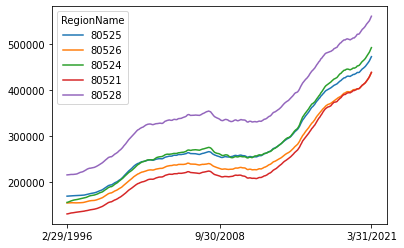

In [386]:
transp = ZipCodes.transpose()
y = transp.iloc[0]
transp = transp[1:-2]
x = transp.iloc[4:, :].shape[0]
transp.columns = y
(transp.iloc[4:, :]).plot(xticks = [0,(x)/2,x-1])

Looking at our ZipCodes graph, we can see that all 5 zip-codes followed the same trends. Steadily increasing until around 2008, during the housing crisis, then booming afterwards until now. Four of our zip-codes seem to be relatively close when it comes to home values. 80528 however, is way above all of them, although still following the same trends.  

Next we will look at the two columns we added onto the end of our dataset. Comparing them to our graph we can see the four clumped on the graph all held similar percentage changes. What I felt to be the most interesting was how our largest (purple, 80528, final row in dataset) had the greatest dollar change but lowest percent change. This is because 80528 started at the highest initial home value in 1996, and although reaching the highest value in 2021, it saw the lowest percentage increase. Percentage increase was calculated by taking the dollar change and dividing it by our initial value. 

# Second Question:

What zip-codes are considered affordable and what is their average house value?

In order to understand what makes a home affordable let us take a look at what the United States defines as affordable living. According to the United States Department of Housing and Urban Development (HUD), a home is considered affordable when housing costs are below 30% of individuals income (https://www.huduser.gov/portal/pdredge/pdr-edge-featd-article-081417.html). 

Based off of this information, according to the Census Bureau, the median individual income in Fort Collins is just under \$30,000 (\$29,477 to be exact). Meaning affodrable housing consists of spending \$9,000 yearly on housing expenses; the total cost of rent, utilities, renters insurance, etc.. This means individuals would be subject to spending an average of $750 on housing every month. Unless you have an extremely small loan payment broken up over 50 years, this question/data is more catered towards renters. 

Since we have only been looking at the total home values of zip-codes, we will have to use another dataset. Luckily, Zillow provides data not only for ZHVI but also Zillow Observed Rent Index (ZORI). This ZORI dataset contains information on two zip-codes in the Fort Collins area. The data for these two zip-codes is made up of the 40th-60th percentile of renting prices. Of which the mean is then found for the prices between these percentiles. Because we only have monthly data from 2014-2021, we will be adding a column displaying the ratio of how many months fell under affordable housing. 

In [387]:
# call data and correct the dataset
Renters = pd.read_csv("https://raw.githubusercontent.com/EvanJosef/DSCI235-FinalProject/main/Renters.csv")
Renters = Renters.drop(columns = ['RegionID', 'SizeRank'])
Renters = Renters[Renters['MsaName'] == 'Fort Collins, CO']
Renters.set_index('RegionName')

,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03
RegionName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
80526,"Fort Collins, CO",NaN,NaN,1251.0,1254.0,1320.0,NaN,NaN,1370.0,NaN,NaN,1420.0,NaN,1497.0,1503.0,1446.0,1465.0,1565.0,1531.0,1525.0,1526.0,1493.0,1498.0,1471.0,1500.0,1519.0,1560.0,1554.0,1559.0,1582.0,1596.0,1591.0,1564.0,1552.0,1503.0,1552.0,1536.0,1532.0,1534.0,1564.0,...,1586.0,1493.0,1582.0,1617.0,1648.0,1659.0,1664.0,1666.0,1604.0,1633.0,1630.0,1609.0,1620.0,1638.0,1679.0,1701.0,1699.0,1714.0,1721.0,1725.0,1736.0,1691.0,1685.0,1673.0,1669.0,1681.0,1644.0,1715.0,1715.0,1734.0,1793.0,1790.0,1761.0,1727.0,1722.0,1734.0,1706.0,1734.0,1800.0,1821.0
80537,"Fort Collins, CO",932.0,NaN,NaN,976.0,960.0,989.0,NaN,984.0,1005.0,1043.0,1004.0,1035.0,1037.0,1035.0,1045.0,1034.0,1057.0,NaN,NaN,1026.0,1067.0,1082.0,1112.0,1160.0,1140.0,1142.0,1107.0,1109.0,1118.0,1133.0,1151.0,1128.0,1152.0,1158.0,1170.0,1177.0,1192.0,1188.0,1209.0,...,1212.0,1209.0,1231.0,1237.0,1221.0,1245.0,1254.0,1248.0,1262.0,1243.0,1246.0,1274.0,1279.0,1289.0,1272.0,1296.0,1291.0,1297.0,1285.0,1309.0,1326.0,1318.0,1348.0,1326.0,1333.0,1328.0,1322.0,1339.0,1334.0,1332.0,1351.0,1350.0,1375.0,1383.0,1376.0,1366.0,1364.0,1341.0,1354.0,1390.0


In [388]:
# add new column
Renters = Renters.fillna(0)
temp = ((Renters.iloc[:, 2:] < 750) & (Renters.iloc[:, 2:] > 0)).astype(int)
Renters['Affordable'] = temp.sum(axis = 1)
Renters

,RegionName,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,...,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,Affordable
617,80526,"Fort Collins, CO",0.0,0.0,1251.0,1254.0,1320.0,0.0,0.0,1370.0,0.0,0.0,1420.0,0.0,1497.0,1503.0,1446.0,1465.0,1565.0,1531.0,1525.0,1526.0,1493.0,1498.0,1471.0,1500.0,1519.0,1560.0,1554.0,1559.0,1582.0,1596.0,1591.0,1564.0,1552.0,1503.0,1552.0,1536.0,1532.0,1534.0,...,1493.0,1582.0,1617.0,1648.0,1659.0,1664.0,1666.0,1604.0,1633.0,1630.0,1609.0,1620.0,1638.0,1679.0,1701.0,1699.0,1714.0,1721.0,1725.0,1736.0,1691.0,1685.0,1673.0,1669.0,1681.0,1644.0,1715.0,1715.0,1734.0,1793.0,1790.0,1761.0,1727.0,1722.0,1734.0,1706.0,1734.0,1800.0,1821.0,0
625,80537,"Fort Collins, CO",932.0,0.0,0.0,976.0,960.0,989.0,0.0,984.0,1005.0,1043.0,1004.0,1035.0,1037.0,1035.0,1045.0,1034.0,1057.0,0.0,0.0,1026.0,1067.0,1082.0,1112.0,1160.0,1140.0,1142.0,1107.0,1109.0,1118.0,1133.0,1151.0,1128.0,1152.0,1158.0,1170.0,1177.0,1192.0,1188.0,...,1209.0,1231.0,1237.0,1221.0,1245.0,1254.0,1248.0,1262.0,1243.0,1246.0,1274.0,1279.0,1289.0,1272.0,1296.0,1291.0,1297.0,1285.0,1309.0,1326.0,1318.0,1348.0,1326.0,1333.0,1328.0,1322.0,1339.0,1334.0,1332.0,1351.0,1350.0,1375.0,1383.0,1376.0,1366.0,1364.0,1341.0,1354.0,1390.0,0


Looking at the data we just calculated, the column 'Affordable', we can see that Fort Collins' average rental prices are not affordable related to the median individual income of $750 a month. This seems very questionable. Looking at our dataset again, the data includes all homes plus multifamily. Because of this, instead we will look at the median average income for households instead of indiviudals. Hopefully this will give us at least a few affordable options in Fort Collins.

Changing our basis of income, we will now be looking at our dataset compared to household income. According to the same census we were using above, Fort Collins has a median household income of \$65,866. Breaking this up monthly into again, what the governement depicts as affordable (30% of income), households have anually \$1,646 to spend on rent. 

In [389]:
temp2 = ((Renters.iloc[:, 2:] < 1646) & (Renters.iloc[:, 2:] > 0)).astype(int)
Renters['Affordable'] = temp2.sum(axis = 1)
Renters['Affordable %'] = Renters['Affordable'] / Renters.shape[1]
Renters

,RegionName,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,Affordable,Affordable %
617,80526,"Fort Collins, CO",0.0,0.0,1251.0,1254.0,1320.0,0.0,0.0,1370.0,0.0,0.0,1420.0,0.0,1497.0,1503.0,1446.0,1465.0,1565.0,1531.0,1525.0,1526.0,1493.0,1498.0,1471.0,1500.0,1519.0,1560.0,1554.0,1559.0,1582.0,1596.0,1591.0,1564.0,1552.0,1503.0,1552.0,1536.0,1532.0,1534.0,...,1582.0,1617.0,1648.0,1659.0,1664.0,1666.0,1604.0,1633.0,1630.0,1609.0,1620.0,1638.0,1679.0,1701.0,1699.0,1714.0,1721.0,1725.0,1736.0,1691.0,1685.0,1673.0,1669.0,1681.0,1644.0,1715.0,1715.0,1734.0,1793.0,1790.0,1761.0,1727.0,1722.0,1734.0,1706.0,1734.0,1800.0,1821.0,50,0.555556
625,80537,"Fort Collins, CO",932.0,0.0,0.0,976.0,960.0,989.0,0.0,984.0,1005.0,1043.0,1004.0,1035.0,1037.0,1035.0,1045.0,1034.0,1057.0,0.0,0.0,1026.0,1067.0,1082.0,1112.0,1160.0,1140.0,1142.0,1107.0,1109.0,1118.0,1133.0,1151.0,1128.0,1152.0,1158.0,1170.0,1177.0,1192.0,1188.0,...,1231.0,1237.0,1221.0,1245.0,1254.0,1248.0,1262.0,1243.0,1246.0,1274.0,1279.0,1289.0,1272.0,1296.0,1291.0,1297.0,1285.0,1309.0,1326.0,1318.0,1348.0,1326.0,1333.0,1328.0,1322.0,1339.0,1334.0,1332.0,1351.0,1350.0,1375.0,1383.0,1376.0,1366.0,1364.0,1341.0,1354.0,1390.0,82,0.911111


The numbres given through a monthly rental allowance of a multifamily home, \$1,646/month gave us much better results. Zip-code 80526 (actually the zip-code I live in), gave us 50 months of affordable renting. Around half of those months were affordable. Zip-code 80537 however gives us 82 affordable renting months, almost 93% of the months from 2014-2021 were depicted as affordable under multifamily. 

Because it is broken up by rent, folks with 10-12 month rental contracts wouldn't face these changes. If they got onto their contract in an affordable month they would keep that through the rest of their term. Although, seeing the fluctuation of rentals on the market in these two area codes is surprising. 

Since we are looking at a dataset containing both individual and multifamily rental properties, I would like to try one more thing. As the individual income yielded 0 affordable rentals and the multifamily characterized almost every rent as affordable I would like to take the average between the two. The two referring to our individual and multifamily rental allowances. Those would be \$750/month and \$1,646/month. Giving us a new monthly rental allowance of \$1,198. I feel this would be a much better representation as it takes into consideration both multifamily and individual rentals.

In [390]:
temp3 = ((Renters.iloc[:, 2:] < 1198) & (Renters.iloc[:, 2:] > 0)).astype(int)
Renters['Affordable'] = temp3.sum(axis = 1)
Renters['Affordable %'] = Renters['Affordable'] / Renters.shape[1]
Renters

,RegionName,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,Affordable,Affordable %
617,80526,"Fort Collins, CO",0.0,0.0,1251.0,1254.0,1320.0,0.0,0.0,1370.0,0.0,0.0,1420.0,0.0,1497.0,1503.0,1446.0,1465.0,1565.0,1531.0,1525.0,1526.0,1493.0,1498.0,1471.0,1500.0,1519.0,1560.0,1554.0,1559.0,1582.0,1596.0,1591.0,1564.0,1552.0,1503.0,1552.0,1536.0,1532.0,1534.0,...,1582.0,1617.0,1648.0,1659.0,1664.0,1666.0,1604.0,1633.0,1630.0,1609.0,1620.0,1638.0,1679.0,1701.0,1699.0,1714.0,1721.0,1725.0,1736.0,1691.0,1685.0,1673.0,1669.0,1681.0,1644.0,1715.0,1715.0,1734.0,1793.0,1790.0,1761.0,1727.0,1722.0,1734.0,1706.0,1734.0,1800.0,1821.0,2,0.021978
625,80537,"Fort Collins, CO",932.0,0.0,0.0,976.0,960.0,989.0,0.0,984.0,1005.0,1043.0,1004.0,1035.0,1037.0,1035.0,1045.0,1034.0,1057.0,0.0,0.0,1026.0,1067.0,1082.0,1112.0,1160.0,1140.0,1142.0,1107.0,1109.0,1118.0,1133.0,1151.0,1128.0,1152.0,1158.0,1170.0,1177.0,1192.0,1188.0,...,1231.0,1237.0,1221.0,1245.0,1254.0,1248.0,1262.0,1243.0,1246.0,1274.0,1279.0,1289.0,1272.0,1296.0,1291.0,1297.0,1285.0,1309.0,1326.0,1318.0,1348.0,1326.0,1333.0,1328.0,1322.0,1339.0,1334.0,1332.0,1351.0,1350.0,1375.0,1383.0,1376.0,1366.0,1364.0,1341.0,1354.0,1390.0,38,0.417582


This I believe is a much better distribution of affordable rentals. Even though 80526 holds only 2 affordable rentals, since I am from this area I can say it is mainly made up of multifamily, 2-4 bedroom, townhouses, and condos. These will naturally tend to run a lot more than apartment complexes and other areas of Fort Collins closer to CSU campus. Another factor  80537 again held a significant amount of affordabl renting months, coming in with just under half, 42%.

The last thing I want to do with this question/dataset is a plot.

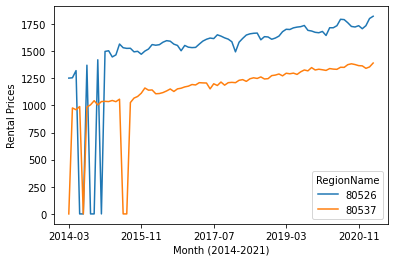

In [391]:
transp2 = Renters.transpose()
y = transp2.iloc[0]
transp2 = transp2[2:-2]
x = transp2.iloc[2:, :].shape[0]
transp2.columns = y
(transp2.iloc[2:, :]).plot(xlabel = "Month (2014-2021)", ylabel = "Rental Prices")

Although looking a bit wonky at the beginning, this graph shows everything we want to see. The only reason we see the initial dips is because of the NaN's we saw speratically at the begining of our dataset. Otherwise we see everything we saw in the data, 80537 has much lower rental pries than 80526, neither of them saw a significant drop or rise in the 7 years we have data for, not even during Covid. 

# Third Question:

Is the appreciation of rental properties similar to the appreciation of homevalues in zip-code 80526 from their similar datarange?

To do this we will need to take our home values dataset and take out the 4 zipcodes that we don't have coressponding data for in the renteres dataset. As well as getting rid of every home value logged before 2014. Similarly with the renters, remove zip-code 80537.

In [396]:
# create and clean
NewRent = Renters[Renters['RegionName'] == 80526]
NewRent.columns.values[1] = "City"
temp4 = ZipCodes.iloc[:, :4]
NewHome = pd.concat([temp4, ZipCodes.iloc[:, 220:]], axis = 'columns')
NewHome = NewHome[NewHome['RegionName'] == 80526]
NewHome.drop(columns = ['State', 'CountyName'])

,RegionName,City,1/31/2014,2/28/2014,3/31/2014,4/30/2014,5/31/2014,6/30/2014,7/31/2014,8/31/2014,9/30/2014,10/31/2014,11/30/2014,12/31/2014,1/31/2015,2/28/2015,3/31/2015,4/30/2015,5/31/2015,6/30/2015,7/31/2015,8/31/2015,9/30/2015,10/31/2015,11/30/2015,12/31/2015,1/31/2016,2/29/2016,3/31/2016,4/30/2016,5/31/2016,6/30/2016,7/31/2016,8/31/2016,9/30/2016,10/31/2016,11/30/2016,12/31/2016,1/31/2017,2/28/2017,...,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021,Change ($),Change (%)
310,80526,Fort Collins,259393.0,260897.0,262218.0,263589.0,264551.0,266168.0,267742.0,269890.0,272023.0,274173.0,276834.0,278845.0,280594.0,282679.0,285843.0,289337.0,294051.0,297623.0,301715.0,304226.0,307609.0,310754.0,313294.0,316161.0,318820.0,322243.0,325208.0,328403.0,330356.0,333198.0,335985.0,339954.0,343250.0,345986.0,348938.0,351192.0,354469.0,356747.0,...,377333.0,378694.0,380286.0,381787.0,383636.0,384832.0,386096.0,387268.0,389683.0,391763.0,393655.0,394206.0,395801,396932,396994,396804,396427,398042,399151,401237,401391,401875,402268,403151,403151,403723,406106,408585,411030,412599,414704,416480,419323,422318,425614,429436,433764,438269,283194.0,1.826174


In [397]:
NewRent

,RegionName,City,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,Affordable,Affordable %
617,80526,"Fort Collins, CO",0.0,0.0,1251.0,1254.0,1320.0,0.0,0.0,1370.0,0.0,0.0,1420.0,0.0,1497.0,1503.0,1446.0,1465.0,1565.0,1531.0,1525.0,1526.0,1493.0,1498.0,1471.0,1500.0,1519.0,1560.0,1554.0,1559.0,1582.0,1596.0,1591.0,1564.0,1552.0,1503.0,1552.0,1536.0,1532.0,1534.0,...,1582.0,1617.0,1648.0,1659.0,1664.0,1666.0,1604.0,1633.0,1630.0,1609.0,1620.0,1638.0,1679.0,1701.0,1699.0,1714.0,1721.0,1725.0,1736.0,1691.0,1685.0,1673.0,1669.0,1681.0,1644.0,1715.0,1715.0,1734.0,1793.0,1790.0,1761.0,1727.0,1722.0,1734.0,1706.0,1734.0,1800.0,1821.0,2,0.021978


(<matplotlib.axes._subplots.AxesSubplot at 0x7f24318bb810>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f24313c8bd0>)

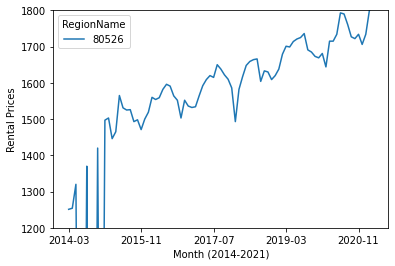

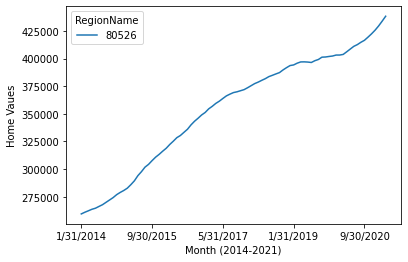

In [408]:
# plot New Rent
TranspNewRent = NewRent.transpose()
y = TranspNewRent.iloc[0]
TranspNewRent = TranspNewRent[2:-2]
TranspNewRent.columns = y
# plot New Home
TranspNewHome = NewHome.transpose()
y = TranspNewHome.iloc[0]
TranspNewHome = TranspNewHome[2:-2]
TranspNewHome.columns = y
# Display
display((TranspNewRent.iloc[2:, :].plot(xlabel = "Month (2014-2021)", ylabel = "Rental Prices", ylim = (1200,1800)), 
        TranspNewHome.iloc[2:, :].plot(xlabel = "Month (2014-2021)", ylabel = "Home Vaues")))

I wrote this next statement before changing the y limits on our Rental graphs from including the \$0 outliers to restricting the y values to 1200-1800. I did not want to straight up delete my thoughts after seeing what the two graphs looked like, severely dissimilar. 
> *Initially I thought that these two graphs would look relatively similar, at least have similar paths. Now looking at it I can see that our Home Values nearly doubled in the 7 year time frame from 2014-2021 wile our rental prices hardly budged, increasaing about 500 to 600 dollars. I can recognize that there is a massive difference in y values but that does not take away from the fact that they could have similar paths.*

Now, after fixing the range the graphs actually follow very similar paths. They begin to steaply increase, although our rentals are very jagged you can see the general route it is taking, and around 2019 they both begin to level off. It makes perfect sense as to why, these are two graphs depiciting the home values and the rental prices of the same exact area in Fort Collins, Colorado. If home values begin to increase naturally rent prices will follow, whether there is more demand in that area or nicer houses, they will go hand in hand. 




# Fourth Question:


What demographics commonly make up certain zip-codes?

At the time of my proposal, this question seemed to be a great opportunity to split up the data. Although, after doing some research of the demographic make up of Fort Collins I found that this question is actualy quite unrealstic. First of all, there is not true information on demographic broken up by zip-code. This seemed invasive, time consuming, and not worth the effort. Especially after finding out the percentages of demographics in Fort Collins. 

According to the U.S. Census Bureau, in 2019 79.9% of Fort Collins residents are white with no hispanic or latino heritage. The next highest being Hispanic with 11%. After these two, there were no other demographics making up more than 4% of Fort Collins population (https://www.census.gov/quickfacts/fortcollinscitycolorado). After reading about this, I decided that sorting home values through demographics would be quite useless if not entirely unfeasible. 